In [ ]:
import numpy as np
import vedo
import os
from tqdm import tqdm
from MeshObject import *
import pandas as pd
from Pipeline import *

shape_path_orig = "../ShapeDatabase_INFOMR_orig"
# HISTOGRAM FOR EACH NORMALIZATION STEP
# FOR PCA STEP - COMPUTE PCA FIRST, THEN COMPUTE PCA SECOND TIME ON ALIGNED SHAPE = IF DOT PRODUCT IS 1 FOR ONE (OR ALL?) AXIS - IT'S ALL GOOD

In [ ]:
def object_statistics(mesh: MeshObject):
    return {
        "name": mesh.name,
        "class": mesh.class_type,
        "nfaces": mesh.n_faces,
        "nvertices": mesh.n_vertices,
        "face_type": mesh.face_type,
        "bounding_box": mesh.bounding_box
    }

def dataset_statistics(shape_path):
    #### BOUNDING BOX!! AXIS ALIGNED VIA XMAX-XMIN - compare with builtin bounds()
    stats = {
        "name": [],
        "class": [],
        "nfaces": [],
        "nvertices": [],
        "face_type": [],
        "bounding_box": []
    }

    # remove any directories that might not contain .obj files
    classes = [class_type for class_type in os.listdir(shape_path_orig) if os.path.isdir((os.path.join(shape_path_orig, class_type))) and class_type != ".git"]
    for class_type in tqdm(classes):
        class_path = os.path.join(shape_path_orig, class_type)

        for obj_name in os.listdir(class_path):
            obj_path = os.path.join(class_path, obj_name)
            obj = MeshObject(obj_path, False, name=obj_name, class_type=class_type)

            # add to global dictionary
            obj_stats = object_statistics(obj)
            for attribute in stats.keys():
                stats[attribute].append(obj_stats[attribute]) 

    return stats

stats = dataset_statistics(shape_path_orig)

In [ ]:
df = pd.DataFrame(stats)
# df.to_csv("original_data_statistics.csv", index=False)
df.to_pickle("original_data_statistics.pickle")
df

# Finding different shapes accroding to vertex/face count

In [ ]:
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
avg_vertex_num = np.mean(df.nvertices)
avg_face_num = np.mean(df.nfaces)

vertex_avg = np.argmin([abs(shape-avg_vertex_num) for shape in df.nvertices.to_numpy()])
face_avg = np.argmin([abs(shape-avg_face_num) for shape in df.nfaces.to_numpy()])

vertex_min = np.argmin(df.nvertices.to_numpy())
face_min = np.argmin(df.nfaces.to_numpy())

vertex_max = np.argmax(df.nvertices.to_numpy())
face_max = np.argmax(df.nfaces.to_numpy())

print(f"ID of shape with an average count of vertices {vertex_avg}={df.iloc[vertex_avg].nvertices}, with the average number being {avg_vertex_num:.3f}")
print(f"ID of shape with an average count of vertices {face_avg}={df.iloc[face_avg].nfaces}, with the average number being {avg_face_num:.3f}")
print("-----------------")
print(f"ID of shape with lowest count of vertices {vertex_min}={df.iloc[vertex_min].nvertices}")
print(f"ID of shape with lowest count of faces {face_min}={df.iloc[face_min].nfaces}")
print("-----------------")
print(f"ID of shape with highest count of vertices {vertex_max}={df.iloc[vertex_max].nvertices}")
print(f"ID of shape with highest count of faces {face_max}={df.iloc[face_max].nfaces}")

## Average shape

In [ ]:
avg_shape_vertex = df.iloc[vertex_avg]
avg_shape_face = df.iloc[face_avg]
avg_shape_vertex, avg_shape_face

In [ ]:
mesh = MeshObject(os.path.join(shape_path_orig, avg_shape_vertex["class"], avg_shape_vertex["name"]), visualize=True)
mesh.plotter.title = "Average shape in terms of number of vertices"
mesh.show()

In [ ]:
mesh = MeshObject(os.path.join(shape_path_orig, avg_shape_face["class"], avg_shape_face["name"]), visualize=True)
mesh.plotter.title = "Average shape in terms of number of faces"
mesh.show()

## Minimum shape

In [ ]:
min_shape_vertex = df.iloc[vertex_min]
min_shape_face = df.iloc[face_min]
min_shape_vertex, min_shape_face

In [ ]:
mesh = MeshObject(os.path.join(shape_path_orig, min_shape_vertex["class"], min_shape_vertex["name"]), visualize=True)
mesh.plotter.title = "Smallest shape in terms of number of vertices"
mesh.show()

In [ ]:
mesh = MeshObject(os.path.join(shape_path_orig, min_shape_face["class"], min_shape_face["name"]), visualize=True)
mesh.plotter.title = "Smallest shape in terms of number of faces"
mesh.show()

## Maximum

In [ ]:
max_shape_vertex = df.iloc[vertex_max]
max_shape_face = df.iloc[face_max]
max_shape_vertex, max_shape_face

In [ ]:
mesh = MeshObject(os.path.join(shape_path_orig, max_shape_vertex["class"], max_shape_vertex["name"]), visualize=True)
mesh.plotter.title = "Biggest shape in terms of number of vertices"
mesh.show()

In [ ]:
mesh = MeshObject(os.path.join(shape_path_orig, max_shape_face["class"], max_shape_face["name"]), visualize=True)
mesh.plotter.title = "Biggest shape in terms of number of faces"
mesh.show()

In [ ]:
df[df["class"] == "Skyscraper"].nvertices.max()

# Overall statistics

In [ ]:
def plot_attribute(df, attribute, estimator):
    label_name_map = {
        "nvertices": "vertices",
        "nfaces": "faces",
        "class": "shapes"
    }

    aux_df = df
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(16,9))
    if type(df[attribute].iloc[0]) is not str:
        mean_value_attribute = np.mean(df[attribute])
        aux_df = df.sort_values(attribute, ascending=False).reset_index(drop=True)
        sns.barplot(data=aux_df, x="class", y=attribute, estimator=estimator) # switch to sum/mean - mean might not be best?
    else:
        mean_value_attribute = np.mean(aux_df["class"].value_counts())
        sns.countplot(data=aux_df, x="class", order=aux_df["class"].value_counts().index) # switch to sum/mean - mean might not be best?
        
    plt.xticks(rotation=90)
    sns.despine()
    if type(df[attribute].iloc[0]) is not str:
        plt.text(x=64, y=mean_value_attribute + mean_value_attribute*0.1, s=f"{mean_value_attribute:.3f}", color="red")
    else:
        plt.text(x=64, y=mean_value_attribute + 2, s=f"{mean_value_attribute:.3f}", color="red")

    plt.hlines(y=mean_value_attribute, xmin=-1, xmax=69, colors="red", linestyles="dashed")
    plt.xlim((-1,69))
    plt.xlabel("Class")
    plt.ylabel(f"Number of {label_name_map[attribute]}")
    plt.show()

In [ ]:
import seaborn as sns

sns.histplot(x=np.log10(df["nvertices"]))

In [ ]:
plot_attribute(df, "nvertices", "max")

In [ ]:
plot_attribute(df, "nfaces", "max")

In [ ]:
plot_attribute(df, "class", None)

In [ ]:
df[(df["nfaces"] < 100) | (df["nvertices"] < 100)].to_pickle("outliers_dataset.pickle")

In [ ]:
import pickle
import pandas as pd

df = pd.read_pickle("original_data_statistics.pickle")
df_outliers = pd.read_pickle("outliers_dataset.pickle")
df_outliers

In [ ]:
def _subdivide_shape(vedo_mesh: MeshObject, subdivision_type: str="centroid", threshold: int=5610):
        if not vedo_mesh.is_manifold():
            return vedo_mesh
        
        match subdivision_type:
            case "loop":
                subdivision_type = 0
            case "linear":
                subdivision_type = 1
            case "adaptive":
                subdivision_type = 2
            case "butterfly":
                subdivision_type = 3
            case "centroid":
                subdivision_type = 4
        last_vertex_count = -1
        while vedo_mesh.n_vertices < threshold:
            vedo_mesh = vedo_mesh.subdivide(1, method=subdivision_type)
            if last_vertex_count == vedo_mesh.n_vertices:
                break
            last_vertex_count = vedo_mesh.n_vertices
        vedo_mesh.decimate(0.5, threshold)

        return vedo_mesh

_subdivide_shape(mesh)

In [ ]:
import numpy as np
import vedo
import os
from tqdm import tqdm
from MeshObject import *
import pandas as pd
from Pipeline import *

# HISTOGRAM FOR EACH NORMALIZATION STEP
# FOR PCA STEP - COMPUTE PCA FIRST, THEN COMPUTE PCA SECOND TIME ON ALIGNED SHAPE = IF DOT PRODUCT IS 1 FOR ONE (OR ALL?) AXIS - IT'S ALL GOOD

# from processing_functions import subdivide_shape

import pickle
import pandas as pd

df = pd.read_pickle("original_data_statistics.pickle")

from Pipeline import *

pipeline = Pipeline(pipeline_parameters={"subdivide": {"threshold": 5610, "subdivision_type": "centroid"}})

from collections import defaultdict
new_path_shape = "../ShapeDatabase_INFOMR"
nontwomanifold_faces = defaultdict(list)
class_type, obj_name = "", ""
iterator = tqdm(zip(df["class"], df["name"]), total=len(df), desc=f"{class_type} - {obj_name}")
ok = []
for class_type, obj_name in iterator:
    path = os.path.join(shape_path_orig, class_type, obj_name)
    new_path = os.path.join(new_path_shape, class_type, obj_name)
    mesh = MeshObject(path, True, class_type=class_type, name=obj_name)

    if mesh.is_manifold():
        mesh: MeshObject = pipeline.normalize_shape(mesh)
    else:
        nontwomanifold_faces[class_type] += [obj_name]
        # mesh = mesh.non_manifold_faces(tol=0).fill_holes()
        # mesh: MeshObject = pipeline.normalize_shape(mesh)

    iterator.set_description(f"{class_type} - {obj_name}")
    vedo.save(mesh, new_path)


In [ ]:
s=defaultdict(list)
for class_type, objs in nontwomanifold_faces.items():
    iterator = tqdm(objs, desc="")
    for obj in iterator:
        mesh = MeshObject(os.path.join(shape_path_orig, class_type, obj), visualize=True)
        iterator.set_description(f"{class_type}={obj}")
        try:
            mesh.non_manifold_faces(tol=0).fill_holes()
        except:
            s[class_type] += [obj]

In [41]:
s

defaultdict(list,
            {'ClassicPiano': ['D00314.obj',
              'D00009.obj',
              'D00605.obj',
              'D00190.obj',
              'D00120.obj',
              'D00784.obj',
              'D00305.obj',
              'D00279.obj',
              'D00034.obj',
              'D00092.obj',
              'D00789.obj',
              'D00233.obj',
              'D00811.obj',
              'D00845.obj',
              'D00561.obj',
              'D00983.obj',
              'D00254.obj',
              'D00579.obj',
              'D00967.obj',
              'D00005.obj'],
             'Humanoid': ['m165.obj', 'm166.obj', 'm219.obj'],
             'Spoon': ['D00474.obj',
              'D00562.obj',
              'D00196.obj',
              'D00669.obj',
              'D00085.obj',
              'D00144.obj',
              'D00517.obj',
              'D00683.obj',
              'D00497.obj',
              'D00842.obj',
              'D00790.obj',
              'D00157.obj

In [2]:
from MeshObject import *
import pymeshfix
shape_path_orig = "../ShapeDatabase_INFOMR_orig"

mesh = MeshObject(shape_path_orig + "/ClassicPiano/D00314.obj", visualize=True)



# fix.plot(show_holes=False)
# fix.repair(verbose=True, joincomp=True, remove_smallest_components=False)
# mesh = MeshObject(fix.mesh, visualize=True)
# mesh.show()
# mesh.non_manifold_faces(remove=False, tol=0)

MeshObject.MeshObject at (0x3768ec0)                                       
file name     : ../ShapeDatabase_INFOMR_orig/ClassicPiano/D00314.obj
color         : gray, rgb=(0.502, 0.502, 0.502), alpha=1.0
elements      : vertices=6,800 polygons=31,047 lines=0
position      : (0, 0, 0)
scaling       : (1.00000, 1.00000, 1.00000)
size          : average=0.806473, diagonal=3.78054
center of mass: (1.60213, 1.49537, 0.980983)
bounds        : x=(0.554, 2.55), y=(0.314, 2.73), z=(-0.0932, 2.02)
celldata      : "GroupIds" (float32), dim=1, range=(0, 0)
31047
[] [1.75962667 1.44791667 1.52143333]


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
pymesh = vedo.utils.vedo2meshlab(vedo_mesh)
    pymesh_set = pymeshlab.MeshSet()
    pymesh_set.add_mesh(pymesh)

        match subdivision_type:
            case "midpoint":
                subdivion_func = pymesh_set.meshing_surface_subdivision_midpoint
            case "loop":
                subdivion_func = pymesh_set.meshing_surface_subdivision_loop
        
        # face_number - number of faces
    # vertex_number - number of vertices
        if pymesh_set.get_topological_measures()["non_two_manifold_edges"] > 0:
            return vedo_mesh

        last_vertex_num = -1
        while pymesh_set.current_mesh().vertex_number() < threshold:
            subdivion_func(iterations=1)
            if last_vertex_num == pymesh_set.current_mesh().vertex_number():
                break
            last_vertex_num = pymesh_set.current_mesh().vertex_number()
        # # face_number - number of faces
        # # vertex_number - number of vertices
        # while pymesh_set.current_mesh().vertex_number() < threshold:
        #     subdivion_func(iterations=1)

        vedo_mesh = MeshObject(pymesh_set.current_mesh(), vedo_mesh.visualize, **{"name": vedo_mesh.name, "class_type": vedo_mesh.class_type})
        return vedo_mesh

[13595 12773 12772] [0.41271    0.12171367 0.78834967]
[16018 16017 16019] [0.41418867 0.12214567 0.75150933]
[12772 13595 12773] [0.41283867 0.121751   0.78845767]
[16018 16017 16019] [0.41400233 0.12209133 0.75165367]
[12785 12784 12790] [0.41354567 0.12195767 0.767397  ]
[13595 12773 12772] [0.412714   0.12171467 0.788353  ]
[13595 12773 12772] [0.412714   0.12171467 0.788353  ]
[12785 12784 12790] [0.41354567 0.12195767 0.767397  ]
[14268 14243 14053] [0.44017    0.13918733 0.82270133]
[14268 14243 14053] [0.44014433 0.139085   0.82271467]
[14268 14243 14053] [0.440145   0.139087   0.82271433]
[14250 14051 14248] [0.42767167 0.129004   0.802014  ]
[14250 14051 14248] [0.42869867 0.12958967 0.803537  ]
[14250 14051 14248] [0.42806367 0.12897133 0.802436  ]
[14250 14051 14248] [0.42869867 0.12958967 0.803537  ]


[vedo.mesh:461] INFO: 
 --------- Non manifold faces ---------
 Average tol.   :  0.8139 +-  0.3717
 Automatic tol. :  0.1628
 Removed faces  : 15
 Recovered faces: 0



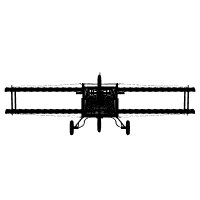

In [2]:
mesh = MeshObject(shape_path_orig + "/Biplane/m1120.obj", visualize=True)
mesh.non_manifold_faces(remove=False)